In [2]:
import os
import lmdb
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from snntoolbox.io_utils.common import to_categorical

#path_to_dataset = '/home/rbodo/.snntoolbox/Datasets/roshambo'
path_to_dataset = '/home/rbodo/Downloads/lmdb_train/test'

lmdb_env = lmdb.open(path_to_dataset)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

x_test = []
y_test = []

for key, value in lmdb_cursor:
    datum = caffe.proto.caffe_pb2.Datum()
    datum.ParseFromString(value)
    x_test.append(caffe.io.datum_to_array(datum) / 255.)
    y_test.append(int(datum.label))

In [6]:
# Separate background samples
x_test_no_background = [x for i, x in enumerate(x_test) if y_test[i] != 3]
y_test_no_background = [y for y in y_test if y != 3]
x_test_background = [x for i, x in enumerate(x_test) if y_test[i] == 3]
y_test_background = [y for y in y_test if y == 3]

In [7]:
len(y_test_no_background)

11676

In [8]:
len(y_test_background)

4200

In [9]:
len(y_test)

15876

In [10]:
np.savez_compressed(os.path.join(path_to_dataset, 'frames_no_background', 'x_norm'), np.array(x_test_no_background, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'frames_no_background', 'x_test'), np.array(x_test_no_background, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'frames_no_background', 'y_test'), np.array(to_categorical(y_test_no_background, 4), dtype='float32'))

In [11]:
np.savez_compressed(os.path.join(path_to_dataset, 'frames_background', 'x_norm'), np.array(x_test_background, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'frames_background', 'x_test'), np.array(x_test_background, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'frames_background', 'y_test'), np.array(to_categorical(y_test_background, 4), dtype='float32'))

In [12]:
np.savez_compressed(os.path.join(path_to_dataset, 'x_norm'), np.array(x_test, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'x_test'), np.array(x_test, dtype='float32'))
np.savez_compressed(os.path.join(path_to_dataset, 'y_test'), np.array(to_categorical(y_test, 4), dtype='float32'))

{'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
Class boundaries: [ 5007  7451 11651 15876]


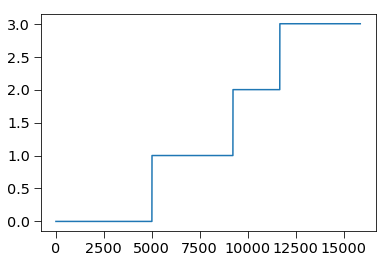

In [13]:
plt.plot(y_test)
class_label_idx = {'0': 'paper', '1': 'scissors', '2': 'rock', '3': 'background'}
print(class_label_idx)
class_sizes = [len(np.nonzero(np.array(y_test)==i)[0]) for i in [0, 2, 3, 1]]
print('Class boundaries: {}'.format(np.cumsum(class_sizes)))

2


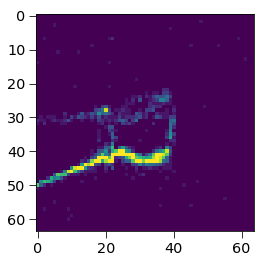

In [14]:
i = 9420
plt.imshow(x_test[i][0])
print(y_test[i])

In [3]:
path = '/home/rbodo/.snntoolbox/data/roshambo'
prototxt = os.path.join(path, 'NullHop.prototxt')
caffemodel = os.path.join(path, 'NullHop.caffemodel')
model = caffe.Net(prototxt, 1, weights=caffemodel)

In [ ]:
# To be executed in the terminal running python2

import sys
sys.path.remove('/mnt/2646BAF446BAC3B9/Repositories/caffe/python')
sys.path.append('/mnt/2646BAF446BAC3B9/Repositories/caffe_lp/python')
import caffe
from caffe.quantization.net_descriptor import net_prototxt
net = net_prototxt()
caffe_root = '/mnt/2646BAF446BAC3B9/Repositories/caffe_lp/'
weight_dir = '/home/rbodo/Downloads/'#'/home/rbodo/.snntoolbox/data/roshambo/'  # Location of caffemodel
save_dir = '/home/rbodo/.snntoolbox/data/roshambo/standard_caffe/'
model_dir = 'examples/low_precision/'  # Put prototxt file there, and append '_deploy' to filename.
net_descr = net.extract('NullHop', caffe_root=caffe_root, model_dir=model_dir, weight_dir=weight_dir)
net.create('NullHop', net_descr, lp=False, deploy=True, caffe_root=caffe_root, model_dir=model_dir, save_dir=save_dir)
# In output file, remove dropout layer (change 'bottom' parameter of following layer) and adapt input layer
net1 = caffe.Net(caffe_root+model_dir+'NullHop_deploy.prototxt', 1, weights=weight_dir+'NullHop/NullHop.caffemodel')
net2 = caffe.Net(save_dir+'NullHop_deploy.prototxt', 1)
for k1, k2 in zip(net1.params.keys(), net2.params.keys()):
    net2.params[k2][0] = net1.params[k1][1]
    net2.params[k2][1] = net1.params[k1][3]
net2.save(save_dir+'NullHop.caffemodel')

In [ ]:
# Generate and save Poisson input

num_to_test = 15876
batch_size = 50
num_batches = int(np.floor(num_to_test / batch_size))
input_rate = 1000
rescale_fac = 1000 / input_rate
duration = 150
num_poisson_events_per_sample = -1

input_b_l_t = np.empty((batch_size, 1, 64, 64, duration), np.bool)

for batch_idx in range(num_batches):
    x_b = np.array(x_test[batch_size*batch_idx: batch_size*(batch_idx+1)])

    input_spikecount = 0
    for sim_step in range(duration):
        if input_spikecount < num_poisson_events_per_sample \
                or num_poisson_events_per_sample < 0:
            spike_snapshot = np.random.random_sample(x_b.shape) * rescale_fac
            inp = (spike_snapshot <= np.abs(x_b)).astype('float32')
            input_spikecount += np.count_nonzero(inp) / batch_size
        else:
            inp = np.zeros(x_b.shape)
        input_b_l_t[Ellipsis, sim_step] = inp

    np.savez_compressed('/home/rbodo/Downloads/' + str(batch_idx), input_b_l_t=input_b_l_t)